In [ ]:
%matplotlib inline
#This is a magic command in Jupyter Notebook or JupyterLab environments that configures matplotlib to display plots directly in the notebook interface.
import numpy as np
import tools
import grader

In [ ]:
# ---------------
# Discussion Cell
# ---------------
num_spaces = 3
num_prices = 3
env = tools.ParkingWorld(num_spaces, num_prices)
# creating an instance of a class named ParkingWorld from the tools module.
V = np.zeros(num_spaces + 1)
pi = np.ones((num_spaces + 1, num_prices)) / num_prices

In Python, enumerate is a built-in function that adds a counter to an iterable (such as a list, tuple, or array) and returns an enumerate object, which contains pairs of the form (index, item). The enumerate function is often used in loops when you want to iterate over both the items and their indices simultaneously.

fruits = ['apple', 'banana', 'cherry']

for index, fruit in enumerate(fruits):
    print(f'Index {index}: {fruit}')

In [ ]:
pi[0] = [0.75, 0.11, 0.14]

for s, pi_s in enumerate(pi):
  #this will go through rows
    for a, p in enumerate(pi_s):
      #this will go through columns
        print(f'pi(A={a}|S={s}) = {p.round(2)}    ', end='')
    print()

In [ ]:
V[0] = 1

tools.plot(V, pi)

When you use the transitions method, it gives you a set of information for each possible new state you might transition to. Specifically, for each new state, it tells you two things:

The reward you'd get for transitioning to that state (this could be a positive or negative value).
The likelihood or probability of actually transitioning to that state based on your current state and action.

In [ ]:
state = 3
action = 1
transitions = env.transitions(state, action)
transitions

Each row has two parts, first is showing your reward and the second showing the probability of this action happening, for example you can move to state 1 or 2 or remain at 3 or move to 4

In [ ]:
for sp, (r, p) in enumerate(transitions):
    print(f'p(S\'={sp}, R={r} | S={state}, A={action}) = {p.round(2)}')

p(S'=0, R=1.0 | S=3, A=1) = 0.12

p(S'=1, R=2.0 | S=3, A=1) = 0.15

p(S'=2, R=3.0 | S=3, A=1) = 0.18

p(S'=3, R=2.0 | S=3, A=1) = 0.54

This update can either occur "in-place" (i.e. the update rule is sequentially applied to each state) or with "two-arrays" (i.e. the update rule is simultaneously applied to each state). Both versions converge to  𝑣𝜋
  but the in-place version usually converges faster.

In [ ]:
# lock
def evaluate_policy(env, V, pi, gamma, theta):
    delta = float('inf')
    while delta > theta:
        delta = 0
        for s in env.S:
            v = V[s]
            bellman_update(env, V, pi, s, gamma)
            delta = max(delta, abs(v - V[s]))

    return V

In [ ]:
# -----------
# Graded Cell
# -----------
def bellman_update(env, V, pi, s, gamma):
    """Mutate ``V`` according to the Bellman update equation."""
    # Update the value function V for state s using the Bellman equation
    ### START CODE HERE ###
    new_v = 0
    for a in env.A:
        for s_, (r,p) in enumerate(env.transitions(s, a)):
             new_v += pi[s,a]*( p*(r+(gamma*V[s_])) )
    V[s] = new_v

In [ ]:
--------------
# Debugging Cell
# --------------
# Feel free to make any changes to this cell to debug your code

# set up test environment
num_spaces = 10
num_prices = 4
env = tools.ParkingWorld(num_spaces, num_prices)

# build test policy
city_policy = np.zeros((num_spaces + 1, num_prices))
city_policy[:, 1] = 1

gamma = 0.9
theta = 0.1

V = np.zeros(num_spaces + 1)
V = evaluate_policy(env, V, city_policy, gamma, theta)

print(V)

In [ ]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

# set up test environment
num_spaces = 10
num_prices = 4
env = tools.ParkingWorld(num_spaces, num_prices)

# build test policy
city_policy = np.zeros((num_spaces + 1, num_prices))
city_policy[:, 1] = 1

gamma = 0.9
theta = 0.1

V = np.zeros(num_spaces + 1)
V = evaluate_policy(env, V, city_policy, gamma, theta)

# test the value function
answer = [80.04, 81.65, 83.37, 85.12, 86.87, 88.55, 90.14, 91.58, 92.81, 93.78, 87.77]

# make sure the value function is within 2 decimal places of the correct answer
assert grader.near(V, answer, 1e-2)

In [ ]:
# lock
tools.plot(V, city_policy)

Now we wnat to improve the Policy

In [ ]:
def improve_policy(env, V, pi, gamma):
    policy_stable = True
    for s in env.S:
        old = pi[s].copy()
        q_greedify_policy(env, V, pi, s, gamma)

        if not np.array_equal(pi[s], old):
            policy_stable = False

    return pi, policy_stable

def policy_iteration(env, gamma, theta):
    V = np.zeros(len(env.S))
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    policy_stable = False

    while not policy_stable:
        V = evaluate_policy(env, V, pi, gamma, theta)
        pi, policy_stable = improve_policy(env, V, pi, gamma)

    return V, pi

In [ ]:
# -----------
# Graded Cell
# -----------
def q_greedify_policy(env, V, pi, s, gamma):
    """Mutate ``pi`` to be greedy with respect to the q-values induced by ``V``."""
    # YOUR CODE HERE
    best_v = float('-inf')
    best_a = 0
    for action in env.A:
        transitions = env.transitions(s,action)
        v = 0
        for s_ in env.S:
            v += transitions[s_][1] * ( transitions[s_][0] + gamma * V[s_] )
        if best_v < v:
            best_v = v
            best_a = action
    pi[s] = np.zeros_like(pi[s])
    pi[s][best_a] = 1

In [ ]:
# --------------
# Debugging Cell
# --------------
# Feel free to make any changes to this cell to debug your code

gamma = 0.9
theta = 0.1
env = tools.ParkingWorld(num_spaces=6, num_prices=4)

V = np.array([7, 6, 5, 4, 3, 2, 1])
pi = np.ones((7, 4)) / 4

new_pi, stable = improve_policy(env, V, pi, gamma)

# expect first call to greedify policy
expected_pi = np.array([
    [0, 0, 0, 1],
    [0, 0, 0, 1],
    [0, 0, 0, 1],
    [0, 0, 0, 1],
    [0, 0, 0, 1],
    [0, 0, 0, 1],
    [0, 0, 0, 1],
])
assert np.all(new_pi == expected_pi)
assert stable == False

# the value function has not changed, so the greedy policy should not change
new_pi, stable = improve_policy(env, V, new_pi, gamma)

assert np.all(new_pi == expected_pi)
assert stable == True

In [ ]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.
gamma = 0.9
theta = 0.1
env = tools.ParkingWorld(num_spaces=10, num_prices=4)

V, pi = policy_iteration(env, gamma, theta)

V_answer = [81.60, 83.28, 85.03, 86.79, 88.51, 90.16, 91.70, 93.08, 94.25, 95.25, 89.45]
pi_answer = [
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 0, 1],
]

# make sure value function is within 2 decimal places of answer
assert grader.near(V, V_answer, 1e-2)
# make sure policy is exactly correct
assert np.all(pi == pi_answer)

In [ ]:
env = tools.ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = policy_iteration(env, gamma, theta)

In [ ]:
tools.plot(V, pi)

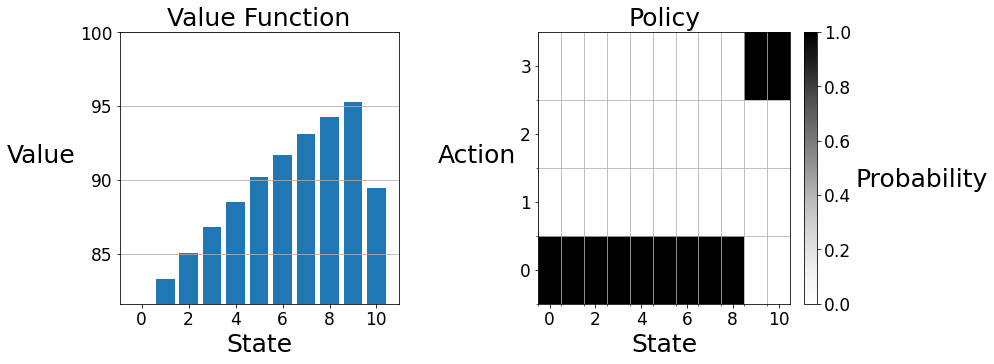

In [ ]:
def value_iteration(env, gamma, theta):
    V = np.zeros(len(env.S))
    while True:
        delta = 0
        for s in env.S:
            v = V[s]
            bellman_optimality_update(env, V, s, gamma)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    for s in env.S:
        q_greedify_policy(env, V, pi, s, gamma)
    return V, pi

In [ ]:
# -----------
# Graded Cell
# -----------
def bellman_optimality_update(env, V, s, gamma):
    """Mutate ``V`` according to the Bellman optimality update equation."""
    best_v = float('-inf')
    for a in env.A:
        v = 0
        transitions = env.transitions(s,a)
        for s_ in env.S:
            v += transitions[s_][1] * ( transitions[s_][0] + gamma*V[s_] )
        if best_v < v:
            best_v = v
    V[s] = best_v

In [ ]:
# --------------
# Debugging Cell
# --------------
# Feel free to make any changes to this cell to debug your code

gamma = 0.9
env = tools.ParkingWorld(num_spaces=6, num_prices=4)

V = np.array([7, 6, 5, 4, 3, 2, 1])

# only state 0 updated
bellman_optimality_update(env, V, 0, gamma)
assert list(V) == [5, 6, 5, 4, 3, 2, 1]

# only state 2 updated
bellman_optimality_update(env, V, 2, gamma)
assert list(V) == [5, 6, 7, 4, 3, 2, 1]

In [ ]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.
gamma = 0.9
env = tools.ParkingWorld(num_spaces=10, num_prices=4)

V = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

for _ in range(10):
    for s in env.S:
        bellman_optimality_update(env, V, s, gamma)

# make sure value function is exactly correct
answer = [61, 63, 65, 67, 69, 71, 72, 74, 75, 76, 71]
assert np.all(V == answer)

In [ ]:
env = tools.ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = value_iteration(env, gamma, theta)

In [ ]:
tools.plot(V, pi)


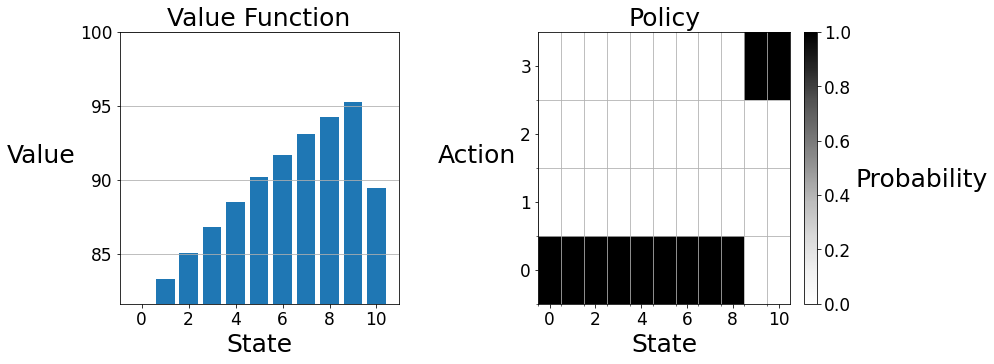

In [ ]:
def value_iteration2(env, gamma, theta):
    V = np.zeros(len(env.S))
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    while True:
        delta = 0
        for s in env.S:
            v = V[s]
            q_greedify_policy(env, V, pi, s, gamma)
            bellman_update(env, V, pi, s, gamma)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V, pi

In [ ]:
env = tools.ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = value_iteration2(env, gamma, theta)
tools.plot(V, pi)

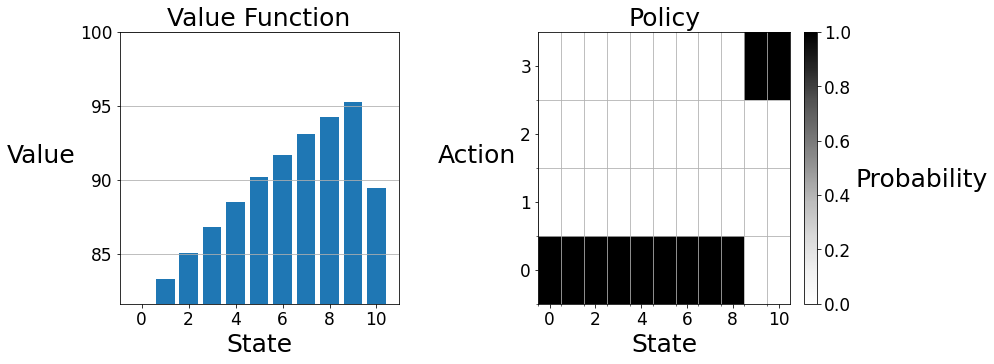